# Import all necessary libraries

In [49]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import cv2
import glob
import string
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.svm import SVC, NuSVC
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

# Import and Integrate data

In [50]:
def getFruits(fruits, set, color="RGB"):
    images = []
    labels = []
        
    for i,f in enumerate(fruits):
        fruitFolder_path = "../fruits-360/" + set + "/" + f
        j=0
        for image_path in glob.glob(fruitFolder_path + "/*.jpg"):
            if(color=="BW"):
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # 100x100
            else:
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # 100x100x3
            images.append(image)
            labels.append(i)
            j+=1
        # print("There are " , j, set, "images of " , fruits[i])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

Import training and testing sets of the 3 fruits

In [51]:
fruits = ['Pineapple' , 'Cocos', 'Avocado']
training_images, training_labels = getFruits(fruits,"Training")
test_images, test_labels = getFruits(fruits,"Test")

# Data Exploration

### - Total training to testing sets ratio

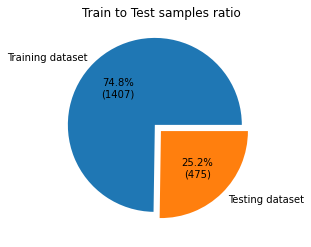

In [52]:
def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, sum(sizes)*x/100)

labels = ['Training dataset', 'Testing dataset']
sizes = [len(training_labels), len(test_labels)]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(facecolor="#FFFFFF")
ax1.pie(sizes, explode=explode, labels=labels, autopct=my_fmt)
plt.title("Train to Test samples ratio")
plt.show()

### - Breakdown of training and testing counts per fruit

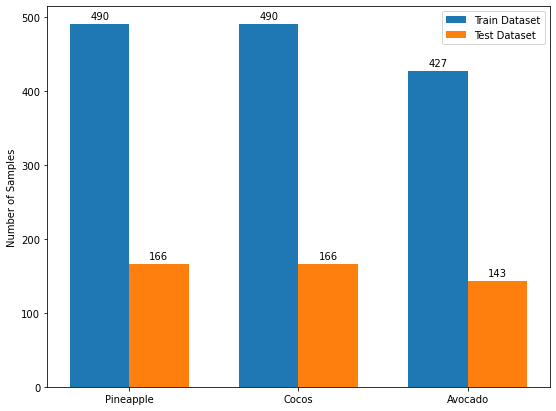

In [53]:
training = Counter(training_labels).values()
testing = Counter(test_labels).values()
x = np.arange(len(fruits))
width = 0.35 

fig, ax = plt.subplots(figsize=(9,7))
rects1 = ax.bar(x - width/2, training, width, label='Train Dataset')
rects2 = ax.bar(x + width/2, testing, width, label='Test Dataset')

ax.set_ylabel('Number of Samples')
ax.set_xticks(x, fruits)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()

### -Grid samples of fruits pictures

In [57]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15), cmap = "RGB"):
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    n = 0
    if(nb_rows == 1 or nb_cols ==1):
            for i in range(0,nb_cols+nb_rows-1):
                axs[i].axis('off')
                if(cmap=="BW"):
                    axs[i].imshow(images[n],cmap="gray")
                else:
                    axs[i].imshow(images[n])
                n += 1
    else:
        for i in range(0, nb_rows):
            for j in range(0, nb_cols):
                axs[i, j].axis('off')
                if(cmap=="BW"):
                    axs[i].imshow(images[n],cmap="gray")
                else:
                    axs[i].imshow(images[n])
                n += 1

25 Images of Pineapple
25 Images of Cocos
25 Images of Avocado


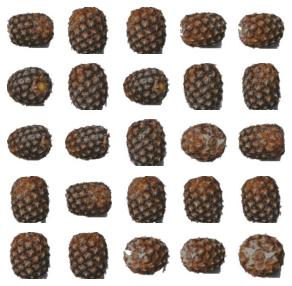

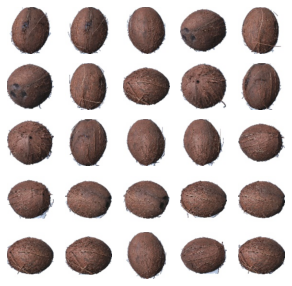

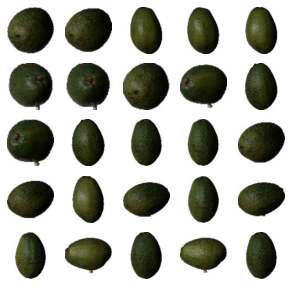

In [55]:
print("25 Images of", fruits[training_labels[0]])
plot_image_grid(training_images[0:25],5,5, (5,5))

print("25 Images of", fruits[training_labels[500]])
plot_image_grid(training_images[500:525],5,5, (5,5))

print("25 Images of", fruits[training_labels[1000]])
plot_image_grid(training_images[1000:1025],5,5, (5,5))

# Data transformation:
&emsp;&emsp;&emsp;&emsp; - Data reduction: Encode RGB pics (100x100x3) into a Grayscale pics (100x100) to reduce dimensionality.<br>
&emsp;&emsp;&emsp;&emsp; - Linearizes each picture (100x100) into a linear array (10,000).

RGB vs GRAYSCALE


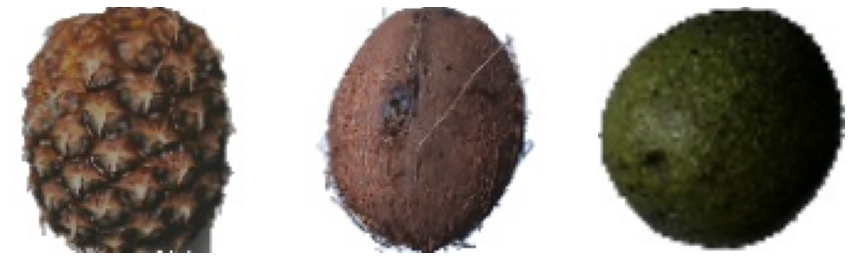

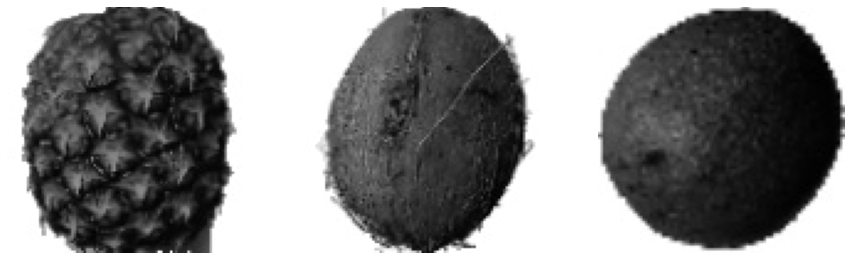

In [58]:
training_images_BW, training_labels = getFruits(fruits,"Training", "BW")
test_images_BW, test_labels = getFruits(fruits,"Test","BW")

X_train = [i.flatten() for i in training_images_BW]
X_test = [i.flatten() for i in test_images_BW]

print("RGB vs GRAYSCALE")
plot_image_grid([training_images[1],training_images[500],training_images[1000]],1,3,(15,10), "RGB")
plot_image_grid([training_images_BW[1],training_images_BW[500],training_images_BW[1000]],1,3,(15,10),"BW")


### - PCA on grayscale images

In [9]:
def performPCA(n, images):
    pca = PCA(n)
    pc = pca.fit_transform(images) # 10,000 -> n
    return pca, pc

In [10]:
# function to reduce dimensions
def perform_and_inverse_PCA(n, images):
    pca, pc = performPCA(n, images) # 10,000 -> n
    reducedBWImages = pca.inverse_transform(pc) # n -> 10,000
    return pc, reducedBWImages

In [11]:
#Compute PCA on train data for 2, 10, 50 PCs
train_pc_2, train_reduced_images_2  = perform_and_inverse_PCA(2, X_train)
train_pc_10, train_reduced_images_10 = perform_and_inverse_PCA(10, X_train)
train_pc_50, train_reduced_images_50 = perform_and_inverse_PCA(50, X_train)

#Compute PCA on test data for 2, 10, 50 PCs
test_pc_2, test_reduced_images_2 = perform_and_inverse_PCA(2, X_test)
test_pc_10, test_reduced_images_10 = perform_and_inverse_PCA(10, X_test)
test_pc_50, test_reduced_images_50 = perform_and_inverse_PCA(50, X_test)


### - Show PCA results on a sample image for 2, 10, 50 principal components

In [62]:
def showPCA(image, imageBW, X50, X10, X2):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,5,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,5,2)
    ax1.axis('off') 
    ax1.set_title('Grayscale')
    plt.imshow(imageBW, cmap="gray")
    ax1 = fig.add_subplot(1,5,3)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50, cmap="gray")
    ax1 = fig.add_subplot(1,5,4)
    ax1.axis('off') 
    ax1.set_title('10 PC')
    plt.imshow(X10, cmap="gray")
    ax2 = fig.add_subplot(1,5,5)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2, cmap="gray")
    plt.show()


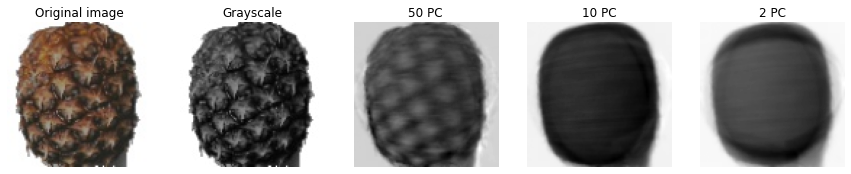

In [63]:
image_id = 1
image = training_images[image_id]
imageBW = training_images_BW[image_id]

#Reshape in order to plot images
X2 = np.reshape(train_reduced_images_2[image_id], (100,100)).astype(int)
X10 = np.reshape(train_reduced_images_10[image_id], (100,100)).astype(int)
X50 = np.reshape(train_reduced_images_50[image_id], (100,100)).astype(int)

# showPCA(image, X2, X10, X50)
showPCA(image,imageBW,X50,X10,X2)

### - Scatter training data in 2D

In [14]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X):
    v = getClassNumber(training_labels)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    for i,index in enumerate(v):
        end = start + index
        plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
        start = end
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(fruits)

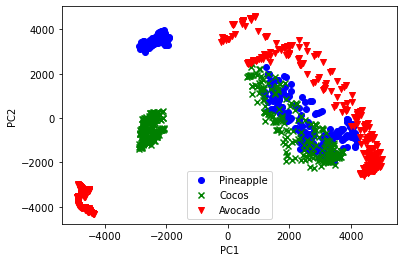

In [15]:
pca2 = PCA(2)
train_pc_2 = pca2.fit_transform(X_train)
plotPrincipalComponents(train_pc_2)

# SVM

### - SVM + PCA

Train and Test SVM model considering different count of PCs to find best accuracy.

Best acuracy obtained for linear SVM classifier with PCA is 56.631578947368425% with PCA of 42 features.


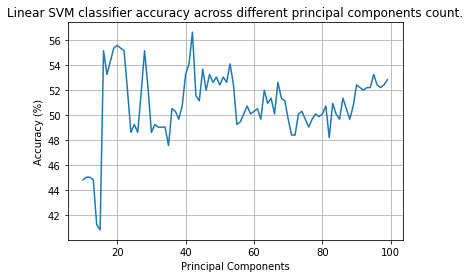

In [16]:
x_graph = list(range(10,100))
y_graph = []
max_accuracy = max_accuracy_pc = 0
for i in x_graph:
    # PCA
    pca, train_pc = performPCA(i, X_train)
    pca, test_pc = performPCA(i, X_test)
    
    # SVM train
    svm = SVC(kernel="linear", probability=True) # Probability = True, enables 5-fold cross validation.
    svm.fit(train_pc, training_labels)
    
    # SVM test
    y_pred=svm.predict(test_pc)
    precision = metrics.accuracy_score(y_pred, test_labels) * 100
    y_graph.append(precision)
    if precision > max_accuracy:
        max_accuracy = precision
        max_accuracy_pc = i

print(f"Best acuracy obtained for linear SVM classifier with PCA is {max_accuracy}% with PCA of {max_accuracy_pc} features.")

plt.plot(x_graph,y_graph)
plt.xlabel("Principal Components")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.title("Linear SVM classifier accuracy across different principal components count.")
plt.show()

Visualize linear SVM decision boundaries after dimensionality reduction to 2 features.

In [ ]:
# PCA reduce dimensions to 2
pca = PCA(n_components=2)
X_train2D = pca.fit_transform(X_train)
X_test2D = pca.fit_transform(X_test)

# SVM train
svm = SVC(kernel='linear', probability=True) # Probability = True, enables 5-fold cross validation.
svm.fit(X_train2D, training_labels) 

# SVM test
test_predictions = svm.predict(X_test2D)
precision = metrics.accuracy_score(test_predictions, test_labels) * 100
print("Accuracy with SVM considering only first 2PC: {0:.2f}%".format(precision))

# plot decision boundry
plot_decision_regions(X_train2D, training_labels, clf=svm, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Linear SVM Decision Boundaries with only 2 PCs')
plt.show()

### - SVM without PCA

In [17]:
# SVM train
svm = SVC(kernel="linear", probability=True) # Probability = True, enables 5-fold cross validation.
svm.fit(X_train, training_labels)

# SVM test
y_pred=svm.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100

print(f"Accuracy obtained for linear SVM classifier without PCA is {precision}%.")

Accuracy obtained for linear SVM classifier without PCA is 96.0%.


# SVM with RBF kernel

Best acuracy obtained for RBF SVM classifier with PCA is 93.6842105263158% with PCA of 3 features.


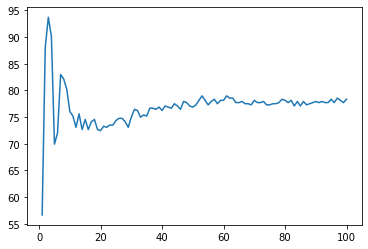

In [18]:
x_graph = list(range(1,101))
y_graph = []
max_accuracy = max_accuracy_pc = 0
for i in x_graph:
    # PCA
    pca, train_pc = performPCA(i, X_train)
    pca, test_pc = performPCA(i, X_test)
    
    # SVM train
    svm = SVC(kernel="rbf", probability=True) # Probability = True, enables 5-fold cross validation.
    svm.fit(train_pc, training_labels)
    
    # SVM test
    y_pred=svm.predict(test_pc)
    precision = metrics.accuracy_score(y_pred, test_labels) * 100
    y_graph.append(precision)
    if precision > max_accuracy:
        max_accuracy = precision
        max_accuracy_pc = i

print(f"Best acuracy obtained for RBF SVM classifier with PCA is {max_accuracy}% with PCA of {max_accuracy_pc} features.")

plt.plot(x_graph,y_graph)
plt.show()

Accuracy with RBF considering only first 2PC: 88.00%


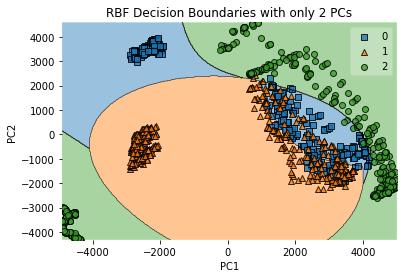

In [19]:
# PCA reduce dimensions to 2
pca = PCA(n_components=2)
X_train2D = pca.fit_transform(X_train)
X_test2D = pca.fit_transform(X_test)

# SVM train
svm = SVC(kernel='rbf', probability=True) # Probability = True, enables 5-fold cross validation.
svm.fit(X_train2D, training_labels) 

# SVM test
test_predictions = svm.predict(X_test2D)
precision = metrics.accuracy_score(test_predictions, test_labels) * 100
print("Accuracy with RBF considering only first 2PC: {0:.2f}%".format(precision))

# plot decision boundry
plot_decision_regions(X_train2D, training_labels, clf=svm, legend=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('RBF Decision Boundaries with only 2 PCs')
plt.show()

### - RBF without PCA

In [20]:
# SVM train
svm = SVC(kernel="rbf", probability=True)
svm.fit(X_train, training_labels)

# SVM test
y_pred=svm.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100
print(f"Accuracy with RBF: {precision}%")

Accuracy with RBF: 96.84210526315789%


# KNN

### - KNN + PCA

In [21]:
max_accuracy = max_accuracy_pc = max_accuracy_k = 0
for k in range(1, 101):
    for p in range(2, 11):
        # PCA
        pca, train_pc = performPCA(p, X_train)
        pca, test_pc = performPCA(p, X_test)
        
        # Train
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train_pc, training_labels)
        #Test
        y_pred = knn.predict(test_pc)
        precision = metrics.accuracy_score(y_pred, test_labels) * 100
        
        if precision > max_accuracy:
            max_accuracy = precision
            max_accuracy_pc = p
            max_accuracy_k = k

print(f"Max accuracy: {max_accuracy}% with {max_accuracy_pc} principal components, and {max_accuracy_k} nearest neighbours.")


Max accuracy: 93.05263157894737% with 9 principal components, and 13 nearest neighbours.


### - KNN without PCA

Max accuracy: 97.89473684210527% with 3 nearest neighbours.


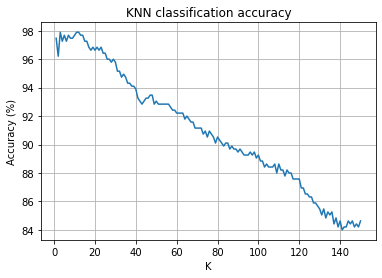

In [22]:
x_graph = list(range(1,151))
y_graph = []
max_accuracy = max_accuracy_k = 0

for k in x_graph:     
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, training_labels)
    
    y_pred = knn.predict(X_test)
    precision = metrics.accuracy_score(y_pred, test_labels) * 100
    y_graph.append(precision)
    if precision > max_accuracy:
        max_accuracy = precision
        max_accuracy_k = k

print(f"Max accuracy: {max_accuracy}% with {max_accuracy_k} nearest neighbours.")
plt.plot(x_graph, y_graph)
plt.xlabel("K")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.title("KNN classification accuracy")
plt.show()

# DECISION TREES

### - DT + PCA

max_accuracy: 88.8421052631579 at 3 principal components and tree of 22 depth.


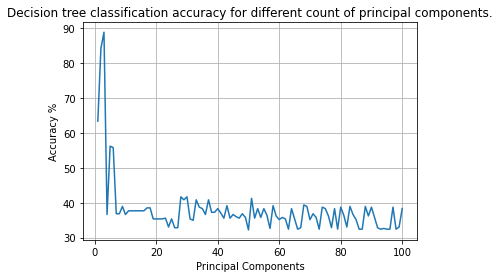

In [23]:
max_accuracy = max_accuracy_pc = max_accuracy_d = 0
x_graph = list(range(1,101))
y_graph = []
for p in x_graph:
    # PCA
    pca, train_pc = performPCA(p, X_train)
    pca, test_pc = performPCA(p, X_test)
    
    # SVM train
    dt = DecisionTreeClassifier(criterion='entropy')
    dt.fit(train_pc, training_labels)
    
    # SVM test
    y_pred=dt.predict(test_pc)
    precision = metrics.accuracy_score(y_pred, test_labels) * 100
    y_graph.append(precision)
    if precision > max_accuracy:
        max_accuracy = precision
        max_accuracy_d = dt.get_depth()
        max_accuracy_pc = p

plt.plot(x_graph,y_graph)
plt.xlabel("Principal Components")
plt.ylabel("Accuracy %")
plt.grid()
plt.title("Decision tree classification accuracy for different count of principal components.")
print("max_accuracy:", max_accuracy, "at", max_accuracy_pc, "principal components and tree of", max_accuracy_d, "depth.")

### - DT without PCA

In [28]:
# SVM train
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, training_labels)

# SVM test
y_pred=dt.predict(X_test)
precision = metrics.accuracy_score(y_pred, test_labels) * 100

print(f"accuracy: {precision}% with a tree of", dt.get_depth(), "depth levels.")

accuracy: 93.6842105263158% with a tree of 7 depth levels.
